In [21]:
import os
import glob
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [37]:
dfs = []
for fname in glob.glob("../data/game_data/*.csv"):
    dfs.append(pd.read_csv(fname))
df = pd.concat(dfs)
df.Date = pd.to_datetime(df.Date)
df = df.sort_values("Date").reset_index()
df["poss"] = 0.5*(df["WFGA"] + 0.44*df["WFTA"] - df["WOR"] + df["WTO"] + df["LFGA"] + 0.44*df["LFTA"] - df["LOR"] + df["LTO"])
print("Shape:",df.shape)
df.head(10)

Shape: (54760, 37)


,index,Season,Date,Type,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
0,0,2011,2010-11-08,RG,illinois,79,california-irvine,65,H,0,...,14,22,11,26,12,14,7,1,21,74.90
1,3,2011,2010-11-08,RG,pittsburgh,83,rhode-island,75,H,0,...,13,16,9,20,16,16,7,6,25,75.62
2,1,2011,2010-11-08,RG,maryland,105,seattle,76,H,0,...,17,22,13,16,11,27,18,1,31,98.36
3,2,2011,2010-11-08,RG,texas,83,navy,52,H,0,...,10,18,5,21,8,16,5,5,24,80.44
4,4,2011,2010-11-10,RG,maryland,75,college-of-charleston,74,H,0,...,16,19,10,25,12,22,8,8,19,77.64
5,5,2011,2010-11-10,RG,pittsburgh,97,illinois-chicago,54,H,0,...,7,9,5,15,9,11,0,3,18,67.88
6,6,2011,2010-11-10,RG,illinois,84,toledo,45,H,0,...,10,19,3,16,9,23,6,0,14,72.00
7,7,2011,2010-11-10,RG,texas,89,louisiana-tech,58,H,0,...,13,20,13,25,4,22,6,5,21,83.74
8,78,2011,2010-11-12,RG,tulane,91,maryland-eastern-shore,62,A,0,...,19,26,9,16,11,21,4,2,28,78.04
9,77,2011,2010-11-12,RG,marquette,97,prairie-view,58,H,0,...,7,11,3,13,12,20,11,3,27,79.12


In [38]:
def partition_games(df, frac=0.7):
    """Returns a 2-tuple of arrays containing the indices.
       The first are the indices in the dataframe that correspond to the
       first <frac> games of each season. The second are the indices
       that correspond to the last <1-frac> games of each season.
       Assumes that the games are already sorted into chronological order.
    """
    years = sorted(df.Season.unique())
    first, second = [], []
    for year in years:
        idcs = list(df.index[df.Season==year])
        thresh = int(len(idcs)*frac)
        first += idcs[:thresh]
        second += idcs[thresh:]
        
    return first, second
    
first, second = partition_games(df)
print(df.iloc[first].shape[0], df.iloc[second].shape[0])

38328 16432


In [63]:
def compute_season_stats(df):
    """Take the per-game data frame and aggregate stats on a per team/season basis"""
    
    STATNAMES = ["Score","FGM","FGA","FGM3","FGA3","FTM","FTA","OR","DR","Ast","TO","Stl","Blk","PF"]
    stats = {}
    for irow,row in df.iterrows():
        year = row.Season
        wid = row.WTeamID
        lid = row.LTeamID
        if year not in stats:
            stats[year] = {}
       
        # initialize values if we haven't seen this team yet
        for tid in (wid,lid):
            if tid not in stats[year]:
                stats[year][tid] = {}
                stats[year][tid]["wins"] = 0
                stats[year][tid]["losses"] = 0
                stats[year][tid]["totOT"] = 0
                for sn in STATNAMES:
                    stats[year][tid]["T"+sn] = 0
                    stats[year][tid]["O"+sn] = 0
        
        for sn in STATNAMES:
            stats[year][wid]["T"+sn] += row["W"+sn]
            stats[year][wid]["O"+sn] += row["L"+sn]
            stats[year][lid]["T"+sn] += row["L"+sn]
            stats[year][lid]["O"+sn] += row["W"+sn]
        stats[year][wid]["wins"] += 1
        stats[year][lid]["losses"] += 1
        stats[year][wid]["totOT"] += row.NumOT
        stats[year][lid]["totOT"] += row.NumOT
        
    ascols = defaultdict(list)
    for year in sorted(stats.keys()):
        for tid in sorted(stats[year].keys()):
            ascols["year"].append(year)
            ascols["team_id"].append(tid)
            ascols["wins"].append(stats[year][tid]["wins"])
            ascols["losses"].append(stats[year][tid]["losses"])
            ascols["totOT"].append(stats[year][tid]["totOT"])
            for sn in STATNAMES:
                ascols["T"+sn].append(stats[year][tid]["T"+sn])
                ascols["O"+sn].append(stats[year][tid]["O"+sn])

    return (pd.DataFrame(ascols, 
                        columns=["year","team_id","wins","losses","totOT"] + \
                        ["T"+sn for sn in STATNAMES] + \
                        ["O"+sn for sn in STATNAMES]),
            stats)

season_stats, season_stats_dict = compute_season_stats(df.iloc[first])
print(season_stats.shape)
season_stats.head()

(3497, 33)


,year,team_id,wins,losses,totOT,TScore,TFGM,TFGA,TFGM3,TFGA3,...,OFGA3,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF
0,2011,air-force,12,8,2,1328,463,941,133,333,...,491,226,309,214,410,275,250,109,56,376
1,2011,akron,12,10,2,1498,527,1263,175,508,...,371,310,462,216,538,277,331,139,52,390
2,2011,alabama,15,7,1,1493,566,1249,96,311,...,386,271,417,229,424,215,345,139,90,348
3,2011,alabama-am,6,10,0,959,348,896,62,237,...,271,205,353,170,387,207,275,125,74,307
4,2011,alabama-birmingham,16,6,5,1537,547,1224,166,480,...,370,241,361,220,446,255,278,138,78,392


In [65]:
def add_advanced_stats(df):
    """Add advanced stats to the season stats dataframe"""
    
    for c in ('T','O'):
        df[c+'poss'] = df[c+"FGA"] + 0.44*df[c+"FTA"] - df[c+"OR"] + df[c+"TO"]
        df[c+'eff'] = 100. * df[c+"Score"] / df[c+"poss"]
        df[c+'astr'] = df[c+"Ast"] / (df[c+"FGA"] + 0.44*df[c+"FTA"] + df[c+"Ast"] + df[c+"TO"])
        df[c+'tovr'] = df[c+"TO"] / (df[c+"FGA"] + 0.44*df[c+"FTA"] + df[c+"TO"])
        df[c+'efgp'] = (df[c+"FGM"] + 0.5*df[c+"FGM3"]) / df[c+"FGA"]
        df[c+'orbp'] = df[c+'OR'] / (df[c+'OR'] + df[c+'DR'])
        df[c+'ftr'] = df[c+"FTA"] / df[c+"FGA"]
    df['rawpace'] = 0.5*(df["Tposs"]+df["Oposs"]) / (df["wins"] + df["losses"] + 0.125*df["totOT"])
        
add_advanced_stats(season_stats)
print(season_stats.shape)
season_stats.query('year==2019').sort_values('rawpace').tail()

(3497, 48)


,year,team_id,wins,losses,totOT,TScore,TFGM,TFGA,TFGM3,TFGA3,...,Torbp,Tftr,Oposs,Oeff,Oastr,Otovr,Oefgp,Oorbp,Oftr,rawpace
2903,2019,green-bay,10,12,2,1787,632,1412,184,533,...,0.257468,0.345609,1720.64,108.854845,0.144713,0.158850,0.539202,0.255114,0.360656,77.333933
3000,2019,north-carolina,19,4,1,2031,726,1532,203,535,...,0.276273,0.327023,1776.72,96.019632,0.144185,0.170009,0.489184,0.261494,0.305652,77.711568
3063,2019,savannah-state,7,15,1,1654,581,1508,253,884,...,0.300539,0.241379,1759.56,112.869126,0.183773,0.164379,0.560926,0.273128,0.322668,80.038870
2876,2019,eastern-kentucky,8,14,3,1766,622,1486,189,592,...,0.296044,0.327052,1788.84,105.096040,0.145986,0.188988,0.538293,0.240936,0.409190,80.484469
2887,2019,florida-international,10,10,0,1604,563,1313,169,568,...,0.282468,0.369383,1592.84,106.037016,0.144561,0.192815,0.547049,0.264339,0.367624,80.731000


Text(0.5, 0, 'Pace')

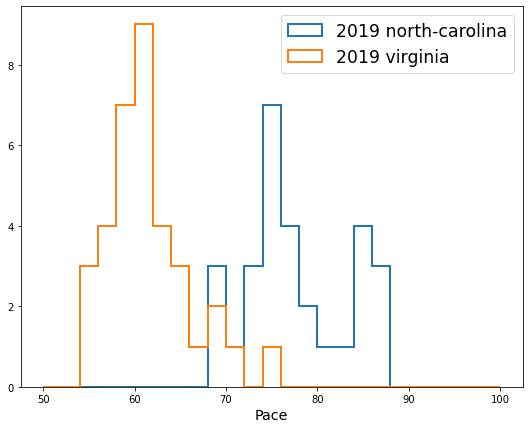

In [103]:
year = 2019
tid1, tid2 = 'north-carolina', 'virginia'
poss1 = df.query(f'Season=={year} & (WTeamID=="{tid1}" | LTeamID=="tid1")').poss.values
poss2 = df.query(f'Season=={year} & (WTeamID=="{tid2}" | LTeamID=="tid2")').poss.values
plt.figure(figsize=(9,7))
plt.hist(poss1, bins=np.linspace(50,100,26), histtype='step', lw=2, label=str(year)+' '+tid1)
plt.hist(poss2, bins=np.linspace(50,100,26), histtype='step', lw=2, label=str(year)+' '+tid2)
plt.legend(fontsize='xx-large')
plt.xlabel('Pace', fontsize='x-large')

In [97]:
mean_poss = {year:season_stats.query(f'year=={year}').rawpace.mean() for year in season_stats.year.unique()}
for i,row in season_stats.iterrows():
    season_stats_dict[row.year][row.team_id]["rawpace"] = row.rawpace

def predict_poss(row):
    p1 = season_stats_dict[row.Season][row.WTeamID]["rawpace"]
    p2 = season_stats_dict[row.Season][row.WTeamID]["rawpace"]
    return p1*p2/mean_poss[row.Season]

pred_poss = df.iloc[second].apply(predict_poss, axis=1).values

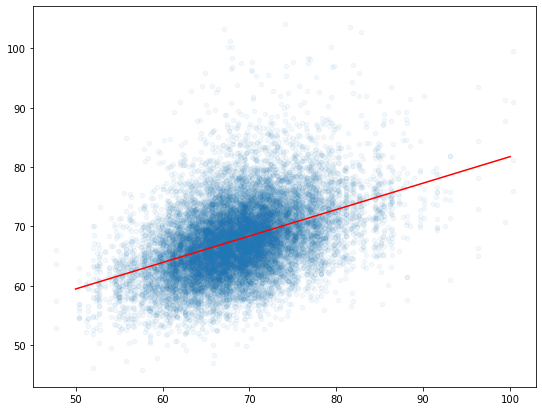

In [98]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(9,7))
xs = pred_poss.reshape(-1,1)
ys = df.iloc[second].poss.values.reshape(-1,1)
plt.scatter(xs, ys, s=20, alpha=0.05)

linreg = LinearRegression()
linreg.fit(xs, ys)
linreg.score(xs,ys)
xl = np.array([50,100]).reshape(-1,1)
yl = linreg.predict(xl)
plt.plot(xl, yl, 'r-')